In [1]:
from numpy.linalg import qr, svd

from scipy.linalg import hadamard, subspace_angles

import math

import jax
import jax.numpy as jnp
from jax import grad, random, vmap
import optax

from kernel_sca import *
from utils import *
from kernels import *

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.decomposition import PCA
from sklearn.linear_model import RidgeCV

import wandb

In [2]:
path = "/Users/ariellerosinski/My Drive/Cambridge/Project/datasets/MC_Maze/psth.npy"
X_raw = np.load(path).swapaxes(1,2) 
X, _ = pre_processing(X_raw, soft_normalize='max', center=False)
K, N, T = X.shape
A = jnp.swapaxes(X, 0, 1)                  #(N, K, T)
A = A.reshape(N,-1)    



In [3]:
X.shape

(108, 30, 35)

In [4]:
l = 1
K_A_X = np.zeros((K*T, K, T))
for k in range(K):
    K_A_X[:,k,:] = K_X_Y_squared_exponential(A, X[k], l = l)
K_A_X = jnp.array(K_A_X)
K_A_A = jnp.array(K_X_Y_squared_exponential(A, A, l = l))

#K_A_A = K_A_A + (jnp.eye((K_A_A.shape[0])) * epsilon)
K_A_A_reshaped = K_A_A.reshape(K,T,K,T)                          #(K,T,K,T)
means = jnp.mean(K_A_A_reshaped, axis=(0, 2), keepdims=True)     #(1, T, 1, T)
K_A_A_tilde = (K_A_A_reshaped - means).reshape(K*T,K*T)          #(K*T,K*T)
P, S, Pt = jnp.linalg.svd(K_A_A_tilde, full_matrices=False)      #P is (K*T, K*T) and S is (K*T,)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Iteration 0, S: 5.173435511096613e-07, S_ratio: 0.2171555608510971
Iteration 10, S: 3.1268643851944944e-07, S_ratio: 0.13943369686603546
Iteration 20, S: 6.016809379616461e-07, S_ratio: 0.1813414990901947
Iteration 30, S: 1.856432845670497e-06, S_ratio: 0.346387654542923
Iteration 40, S: 2.7003050036000786e-06, S_ratio: 0.40105175971984863
Iteration 50, S: 4.6950481191743165e-06, S_ratio: 0.4069964289665222
Iteration 60, S: 1.3701557691092603e-05, S_ratio: 0.48938223719596863
Iteration 70, S: 2.2634527340414934e-05, S_ratio: 0.4582987427711487
Iteration 80, S: 6.230019789654762e-05, S_ratio: 0.42654329538345337
Iteration 90, S: 0.0001903040538309142, S_ratio: 0.3868529498577118
Iteration 100, S: 0.0004977874341420829, S_ratio: 0.3886031210422516
Iteration 110, S: 0.001230055931955576, S_ratio: 0.41866934299468994
Iteration 120, S: 0.002361888764426112, S_ratio: 0.39858272671699524
Iteration 130, S: 0.007919304072856903, S_ratio: 0.49462053179740906
Iteration 140, S: 0.01028339378535747

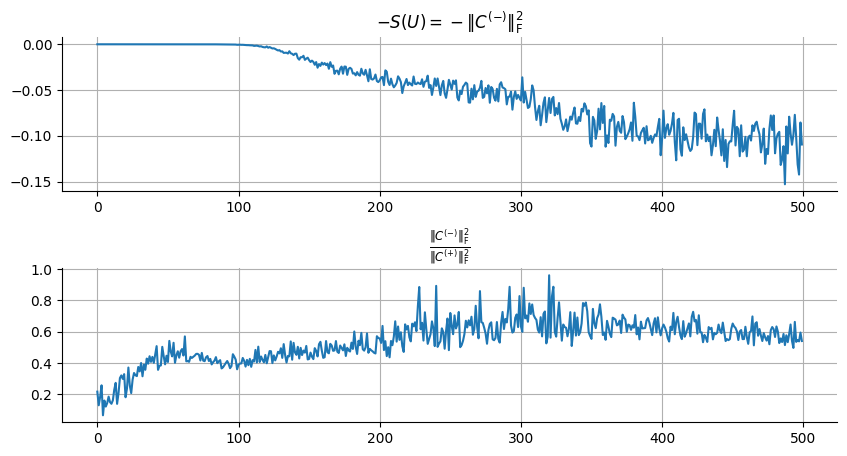

In [5]:
d = 3

wandb.init(project="SCA-project-kernel", name="cpu_local", mode="disabled")
alpha_tilde, ls_loss, ls_S_ratio = optimize(P, S, K_A_X, X, iterations= 500, learning_rate= 0.01, d=d )
wandb.finish()

plt.figure(figsize=(10,5))
plt.subplot(211)
plt.plot(ls_loss)
plt.grid()
plt.title(r"$-S(U) = -\|C^{(-)}\|_\mathrm{F}^2$")
plt.gca().spines[['top','right']].set_visible(False)
plt.subplot(212)
plt.plot(ls_S_ratio)
plt.title(r"$\frac{\|C^{(-)}\|_\mathrm{F}^2}{\|C^{(+)}\|_\mathrm{F}^2}$")
plt.gca().spines[['top','right']].set_visible(False)
plt.grid()
plt.subplots_adjust(hspace=0.5)

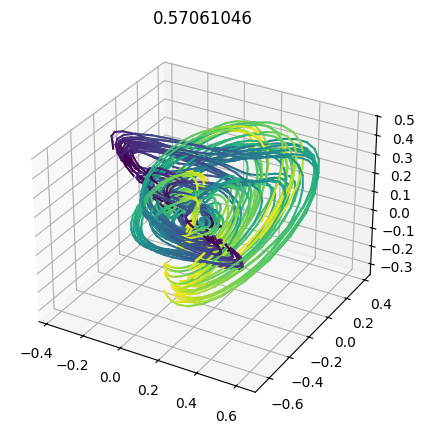

In [6]:
alpha_tilde_QR, _ = jnp.linalg.qr(alpha_tilde)
alpha = (P / jnp.sqrt(S)) @ alpha_tilde_QR

alpha_reshaped = alpha.reshape(K,T,d)                                           #(K, T, d)
mean = jnp.mean(alpha_reshaped, axis=(0), keepdims=True)                        #(1, T, d)
optimized_alpha_H = (alpha_reshaped - mean).reshape(K*T,d)                      #(K*T,d)
projection = jnp.einsum('ij,imk->mjk', optimized_alpha_H, K_A_X)                #(K*T,d) @ (K*T, K, T) --> (K, d, T)


plot_3D(projection)
plt.title(compute_S_all_pairs(projection))

np.save('alpha_tilde', alpha_tilde)
np.save('projection', projection)